# dcr_functions.py testing notebook 

## Updates to make
- [ ] discriminate saturated values (optional)
- [ ] add "bad" and "good" codes as annotation on the individual plots
- [ ] add option to save many plots (user-defined number) as pdf: this could be done with a support function outside from analysis since the indexing permits you to do that

In [1]:
from dcr_functions import *

In [2]:
wf, meta = read_wf("..\\Data\\DCR\\HPKR00030_2cicli_OV5_wf.csv")

In [3]:
time_table = read_wf("..\\Data\\DCR\\HPKR00030_2cicli_OV5_time.csv")

In [12]:
def analysis(wf_table, meta, timestamp_table, custom_n_events=1000, time_adjust=True,
             threshold=0.006, distance=50, many_minima=6250,
             plot=False, save_plot=False):
    """Function to analyze waveform data and locate clean signal peaks.
    
    This function finds all the minima in each waveform (wf) and selects the "good ones" (clean_min) based on
    threshold (V) and distance (#). The resulting dataframe has a column "code" that indicates if
    a clean_min belongs to a good or bad wf: bad wfs are the ones containing a number of relative minima
    bigger than many_minima or that contain -inf saturated data. Notice that the "good" or "bad" coding
    makes sense for discriminating between equally clean_min only: discrimination is not provided for
    minima that are not considered to be "good" signal.
   
   ------
   Input:
   - wf_table: pandas.DataFrame
       Dataframe with waveforms in list mode
   - meta: dict
       Dictionary with metadata of wf_table
   - timestamp_table: pandas.DataFrame
       Dataframe with timestamps
   - custom_n_events: int, default 1000
       Number of events to analyze (starts from the first waveform in any case)
   - time_adjust: bool, default True
       If True, adds timestamps from timestamp_table to wf_table. May be kept
       True for the first time the analysis is run on the dataset, switch
       to False afterwards.
   - threshold: float, default 0.006 [V]
       Minimum value of signal to discriminate it from noise, in units of V
   - distance: int, default 50
       Number of data in between two consecutive absolute minima
   - many_minima: int, default 6250 (# data in single waveform)
       Provide a number of minimum minima to be found to turn on or off a warning 
       that is raised if in the waveform there are more than that number of minima.
       Also provides additional column in dataframe with code "bad_wf" for
       waveforms that satisfy the above condition.
   - plot: bool, default False
       If True, plot the scatterplot of the waveforms with the relative minima in a
       recursive way
   
   --------
   Returns:
   - copy of original dataframe with added columns of minima (total) and clean minima (based
       on threshold and distance)
    
    """
        
    start_time = time.time()
    
    N_of_events = custom_n_events        
    wf_datapoints = len(wf_table)/1000
    
    copy = wf_table.copy()
    general_clean_ampl = []
    general_clean_min = []
    general_bad = []
    time_list = []
    N_bad_wf = 0
        
    for n in range(N_of_events):
        print("Analysis of event number " + str(n+1), end='\r') #'\r' overwrites output
        event_name = 'Event_' + str(n) + '.png'
        
        if time_adjust == True:
            copy["TIME"].loc[wf_datapoints*n: (wf_datapoints*(n+1))-1] += timestamp_table.at[n,"Timestamp"]            
        
        single_wf = copy.loc[wf_datapoints*n: (wf_datapoints*(n+1))-1].copy()
        minimum_list = argrelextrema(single_wf.CH1.values, np.less_equal, order = distance)[0]
        baseline = np.polyfit(single_wf["TIME"].iloc[0:250], single_wf["CH1"].iloc[0:250],0)[0]
        time_list.append(single_wf.TIME.max()-single_wf.TIME.min())

        gap = threshold
        bad_list = []
        clean_minimum_list = []
        previous_index     = minimum_list[0]
        
        for index in minimum_list:
            if (baseline - single_wf["CH1"].iat[index] > gap) and (index > previous_index + distance) and (single_wf["CH1"].iat[index]!=-np.inf):
                clean_minimum_list.append(index)
                general_clean_ampl.append(abs(single_wf["CH1"].iat[index])-abs(baseline))
                previous_index = index
            elif (single_wf["CH1"].iat[index]==-np.inf) or (len(minimum_list) > many_minima):
                bad_list.append(index)
            else:
                bad_list.append(index)
                        
        inf_counts = 0
        inf_counts = len(single_wf[single_wf.CH1==-np.inf])
        if (inf_counts > 0) or (len(minimum_list) > many_minima):
            N_bad_wf += 1
        
        wf_index = (n*wf_datapoints)
        for index in clean_minimum_list:
            general_clean_min.append(index + wf_index)
        for index in bad_list:
            general_bad.append(index + wf_index)
            
            # if len(minimum_list) > many_minima or inf_counts > 0:
            #     general_bad.append(index + wf_index)
        
        # Plotting control (inside loop)
        if plot==True:
            single_wf.loc[:,'min'] = single_wf.iloc[minimum_list]['CH1']
            single_wf.loc[:,'clean_min'] = single_wf.iloc[clean_minimum_list]['CH1']
            single_wf.loc[:,'bad_min'] = single_wf.iloc[bad_list]['CH1']
            plt.plot(single_wf["TIME"], single_wf['CH1'], linestyle="-", linewidth=1)
            # plt.scatter(single_wf["TIME"], single_wf['min'], color="darkred")
            plt.scatter(single_wf["TIME"], single_wf['bad_min'], color="darkred")
            plt.scatter(single_wf["TIME"], single_wf['clean_min'], color="green")
            plt.axhline(baseline, c='b')
            plt.show()
            
        if save_plot==True:
            figure_path = os.path.join(os.path.join(os.getcwd(),'grafici'), event_name)
            plt.savefig(figure_path)
            plt.close()
    
    # Metadata update
    total_time = sum(time_list)
    meta['total acquis time (s)'] = total_time
    meta['n clean minima'] = len(general_clean_min)
    meta['n bad minima'] = len(general_bad)
    meta['DCR (Hz)'] = meta["n clean minima"]/total_time
    
    # Printed output
    print('\nAnalysis completed.')
    print('Number of clean minima found: %d' % len(general_clean_min))
    print('Fraction of waveforms with too many minima or -inf data ("bad_wf") on total: %s%%' % format(N_bad_wf/custom_n_events*100,".2f"))
    print('Total acquisition time: {0:0.3e} s'.format(total_time))
    print('Estimated DCR: {0:0.3e} Hz'.format(meta["n clean minima"]/total_time))
        
    # Return control
    clean_ampl = pd.DataFrame(general_clean_ampl, index=general_clean_min, columns=['ampl_min'])
    if many_minima < 6250 or len(general_bad) > 0:
        bad_code = ['bad_wf' for item in general_bad]
        bad = pd.DataFrame(bad_code, index=general_bad, columns=['code'])
        
    copy.loc[:,'clean_min'] = copy.iloc[general_clean_min]['CH1']
    copy = copy.join(clean_ampl)
    copy = copy.join(bad)
    copy.code.fillna(value='good', inplace=True)
    copy['wfID'] = np.array(range(len(copy))) // 6250
    copy.set_index('wfID', append=True, inplace=True)
    print("Process completed in %s s." % (format(time.time()-start_time,".2f")))
    return copy, meta

In [ ]:
wf_an, meta = analysis(wf_table=wf, meta=meta, timestamp_table=time_table,
                       custom_n_events=100,
                       many_minima=500,
                       threshold = 0.006, distance=50,
                       plot=False,
                      )

In [14]:
wf_delta, meta = analysis_delta_t(wf_an, meta, crosstalk_thr=0.015)

In [15]:
meta

{'path': 'C:\\Users\\MARTINA\\Desktop\\OOPROJECT\\pyproj\\branch_dcr\\Def\\..\\Data\\DCR\\HPKR00030_2cicli_OV5_wf.csv',
 'n events': 1000,
 'data points': 6250,
 'time units': 's',
 'ampl units': 'V',
 'total acquis time (s)': 0.0009998399835458981,
 'n clean minima': 1167,
 'n bad minima': 137570,
 'DCR (Hz)': 1167186.769088064}

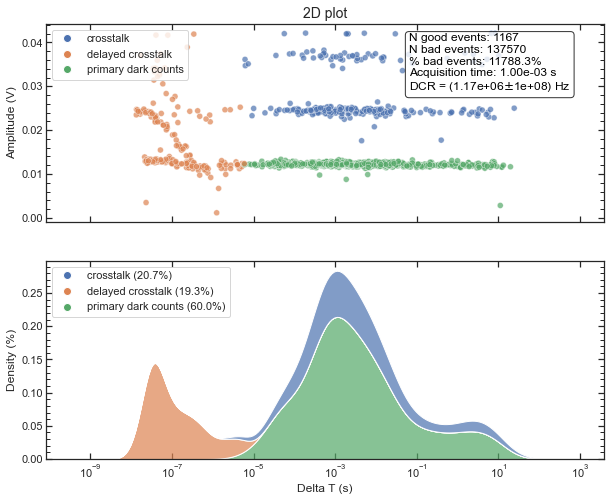

In [16]:
plot_2d(wf_delta, meta)